In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import nltk
from nltk.corpus import stopwords

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

**Ouvrir les CSV et diviser train en train et validation**

In [28]:
df_test = pd.read_csv('../data/test.csv')
df_train = pd.read_csv('../data/train.csv')
df_test 

,doc_id,titre,type,difficulte,cout,ingredients,recette
0,recette_84191.xml,Roulé à la confiture de lait,Dessert,Moyennement difficile,Bon marché,- Pour la garniture: - 1 boîte de lait concent...,"La veille, préparer de la confiture de lait en..."
1,recette_26585.xml,Croissants aux amandes,Dessert,Moyennement difficile,Moyen,- 250 g de farine - 1 pincée de sel - 1 cuillè...,Croissants : Pétrir les ingrédients pour en fa...
2,recette_176139.xml,Quinoa Phileas (aux légumes croquants et sauci...,Plat principal,Moyennement difficile,Moyen,- 250 g de quinoa - 1 gros oignon blanc - 1 g...,Faites cuire le quinoa pendant 12 minutes dans...
3,recette_14285.xml,Magret de canard à la crème de mûre,Plat principal,Moyennement difficile,Moyen,- 1 magret de canard - 5 cl de crème de mûre -...,"Après avoir confectionné la sauce au vin, lui ..."
4,recette_20895.xml,St-Jacques a la sauce aux huitres et aux asperges,Entrée,Moyennement difficile,Moyen,- 10 cl de vin blanc sec - 18 asperges vertes ...,"Ouvrez, videz et nettoyez les coquilles Saint-..."
...,...,...,...,...,...,...,...
1383,recette_20785.xml,Galettes de pommes de terre aux navets,Plat principal,Facile,Moyen,- 750 g de pommes de terre - 750 g de navets -...,Râper les légumes et les assaisonner. Ajouter ...
1384,recette_28768.xml,Terrine d'aubergines au thon de Nadine (4ème r...,Entrée,Facile,Bon marché,"- 4 petits poivrons ou 3 gros, de chaque coule...","Laver les poivrons, les placer entiers dans un..."
1385,recette_73573.xml,Gateau aux amandes et fleur d'oranger,Dessert,Facile,Bon marché,- 250 g de farine - 1/2 sachet de levure - 1...,"Mélanger la farine, la levure, le sucre, la fl..."
1386,recette_166909.xml,Cailles au vin rouge,Plat principal,Facile,Moyen,- 4 - 6 cailles (dépend si ce sont de gros man...,"Tout d'abords, vérifier que vos cailles n'aien..."


In [29]:
df_train, df_validation = train_test_split(df_train, test_size=0.2, random_state=42)
print(df_train.shape, df_validation.shape, df_test.shape)

(9978, 7) (2495, 7) (1388, 7)


In [30]:
df_train.to_csv("../data/train1.csv", index=False)
df_validation.to_csv("../data/validation.csv", index=False)

**Prétraitement**

In [32]:
df_train["text"] = df_train["titre"] + " " + df_train["recette"]
df_test["text"] = df_test["titre"] + " " + df_test["recette"]
df_validation["text"] = df_validation["titre"] + " " + df_validation["recette"]


In [34]:
nltk.download('stopwords')

# Définir les mots-outils en français
stop_words = set(stopwords.words('french'))

def preprocess_text(text):
    # Conversion en minuscules
    text = text.lower()
    # Suppression des mots-outils
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df_validation['text'] = df_validation['text'].apply(preprocess_text)
df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /home/raclax/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df_train['text'])
x_test = vectorizer.transform(df_test['text'])
x_validation = vectorizer.transform(df_validation['text'])

y_train = df_train['type']
y_test = df_test['type']
y_validation = df_validation['type']


encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
y_validation_encoded = encoder.transform(y_validation)

# Afficher la répartition des étiquettes dans chaque sous-ensemble
print("Répartition des étiquettes dans le sous-ensemble d'entraînement (train) :")
print(y_train.value_counts(normalize=True))

print("\nRépartition des étiquettes dans le sous-ensemble de test (test) :")
print(y_test.value_counts(normalize=True))

print("\nRépartition des étiquettes dans le sous-ensemble de validation (validation) :")
print(y_validation.value_counts(normalize=True))


Répartition des étiquettes dans le sous-ensemble d'entraînement (train) :
type
Plat principal    0.465424
Dessert           0.304269
Entrée            0.230307
Name: proportion, dtype: float64

Répartition des étiquettes dans le sous-ensemble de test (test) :
type
Plat principal    0.463977
Dessert           0.293228
Entrée            0.242795
Name: proportion, dtype: float64

Répartition des étiquettes dans le sous-ensemble de validation (validation) :
type
Plat principal    0.464128
Dessert           0.290982
Entrée            0.244890
Name: proportion, dtype: float64


**Baseline (random?)**

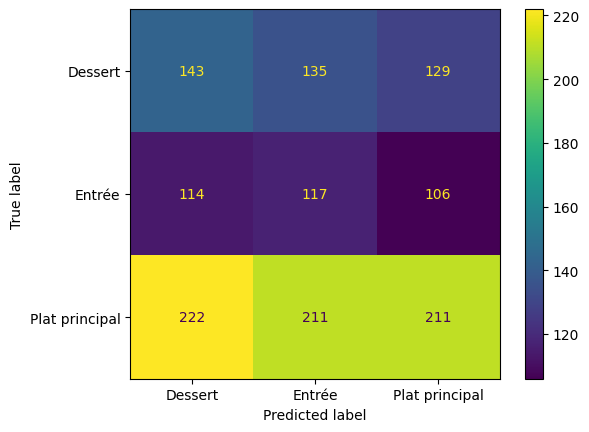

                precision    recall  f1-score   support

       Dessert       0.30      0.35      0.32       407
        Entrée       0.25      0.35      0.29       337
Plat principal       0.47      0.33      0.39       644

      accuracy                           0.34      1388
     macro avg       0.34      0.34      0.33      1388
  weighted avg       0.37      0.34      0.35      1388



In [57]:
classes = np.unique(y_train) 
random_predictions = np.random.choice(classes, size=len(y_test))
generate_confusion_matrix(random_predictions, y_test)
print(classification_report(y_test,random_predictions))


**Arbre de décision**

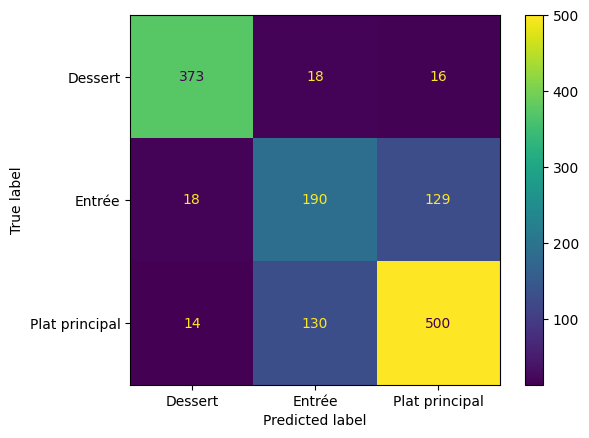

                precision    recall  f1-score   support

       Dessert       0.92      0.92      0.92       407
        Entrée       0.56      0.56      0.56       337
Plat principal       0.78      0.78      0.78       644

      accuracy                           0.77      1388
     macro avg       0.75      0.75      0.75      1388
  weighted avg       0.77      0.77      0.77      1388



In [38]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

generate_confusion_matrix(predictions, y_test)
print(classification_report(y_test,predictions))



**SVM**

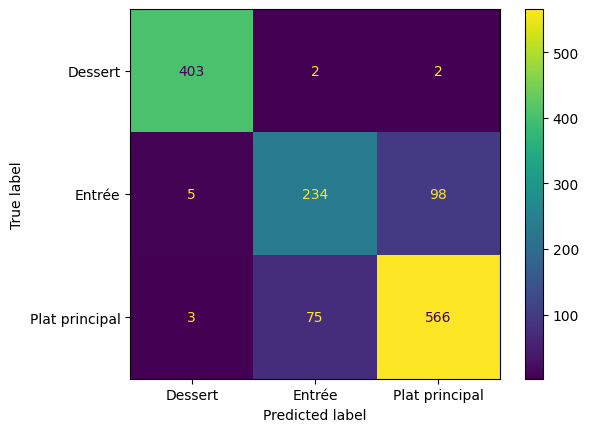

                precision    recall  f1-score   support

       Dessert       0.98      0.99      0.99       407
        Entrée       0.75      0.69      0.72       337
Plat principal       0.85      0.88      0.86       644

      accuracy                           0.87      1388
     macro avg       0.86      0.85      0.86      1388
  weighted avg       0.86      0.87      0.87      1388



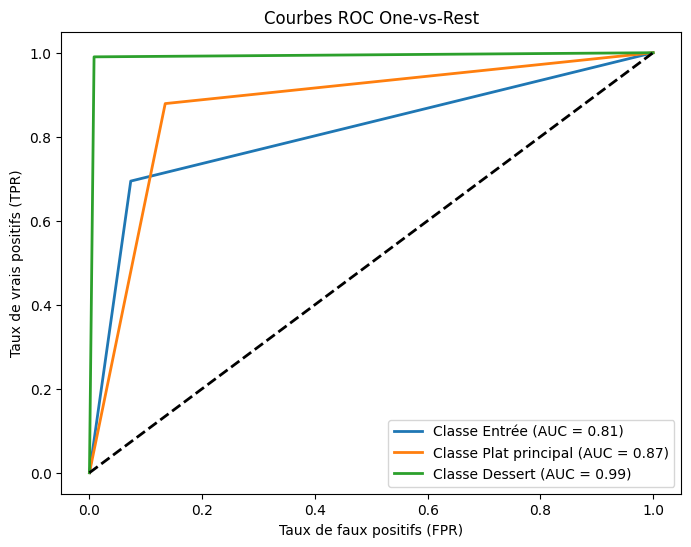

In [56]:

model = SVC(kernel='linear')
model.fit(x_train, y_train_encoded)

y_pred_encoded = model.predict(x_test)

y_pred = encoder.inverse_transform(y_pred_encoded)

generate_confusion_matrix(y_pred, y_test)
print(classification_report(y_test,y_pred))
plot_roc_curve(y_test,y_pred)


**Random forest**

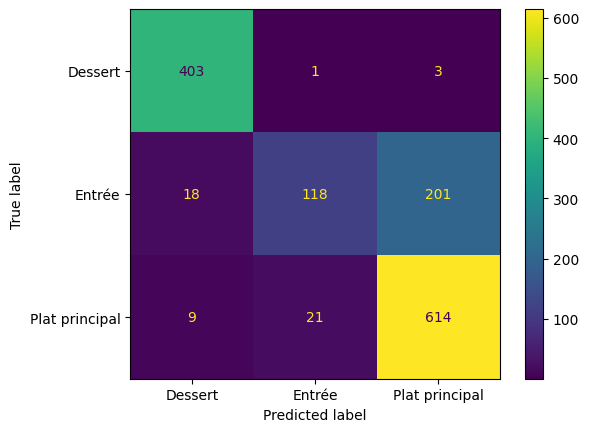

                precision    recall  f1-score   support

       Dessert       0.94      0.99      0.96       407
        Entrée       0.84      0.35      0.49       337
Plat principal       0.75      0.95      0.84       644

      accuracy                           0.82      1388
     macro avg       0.84      0.76      0.77      1388
  weighted avg       0.83      0.82      0.79      1388



In [40]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(x_train, y_train_encoded)

y_pred_encoded = model.predict(x_test)

y_pred = encoder.inverse_transform(y_pred_encoded)

generate_confusion_matrix(y_pred, y_test)
print(classification_report(y_test,y_pred))


**Naive Bayes**

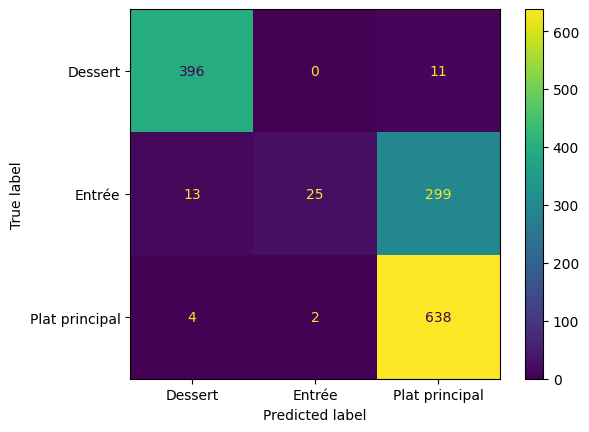

                precision    recall  f1-score   support

       Dessert       0.96      0.97      0.97       407
        Entrée       0.93      0.07      0.14       337
Plat principal       0.67      0.99      0.80       644

      accuracy                           0.76      1388
     macro avg       0.85      0.68      0.63      1388
  weighted avg       0.82      0.76      0.69      1388



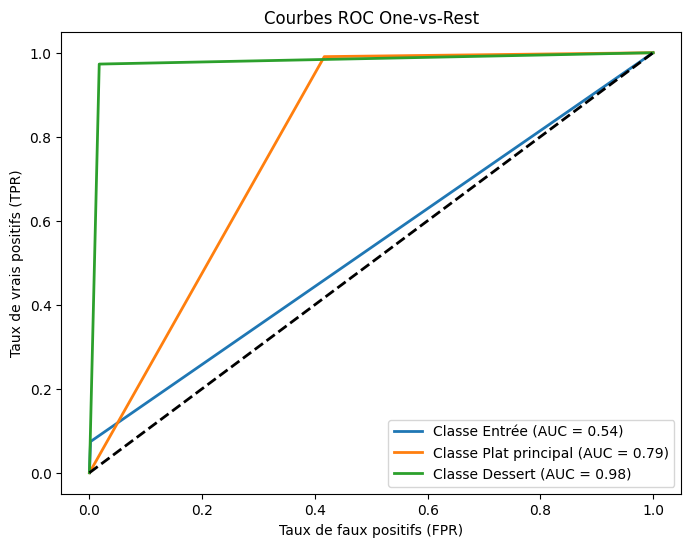

AxisError: axis 1 is out of bounds for array of dimension 1

In [67]:
model = MultinomialNB()
model.fit(x_train, y_train_encoded)

y_pred_encoded = model.predict(x_test)

y_pred = encoder.inverse_transform(y_pred_encoded)

generate_confusion_matrix(y_pred, y_test)
print(classification_report(y_test,y_pred))

plot_roc_curve(y_test,y_pred)
plot_score_distribution(y_pred, y_test)
# import seaborn as sns
# sns.histplot(y_pred, bins=10, kde=True)
# plt.xlabel("Score")
# plt.ylabel("Nombre de documents")
# plt.title("Distribution des scores")
# plt.show()



**Générer une matrice de confusion**

In [36]:
def generate_confusion_matrix(prediction, classes):
    labels = sorted(list(set(classes)))
    cm = confusion_matrix(classes, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

**Afficher la courbe ROC**

In [48]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(y_test, y_pred):
    """
    Affiche la courbe ROC en mode One-vs-Rest pour un problème de classification multi-classes.

    Args:
        y_test: Labels réels des classes (array 1D)
        y_pred: Labels prédits par le modèle (array 1D)
        class_labels: Liste des noms des classes (ex: ["classe_0", "classe_1", "classe_2"])
    """

    class_labels = ["Entrée", "Plat principal", "Dessert"]
    # Vérifier que y_test et y_pred sont bien 1D
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    # Binariser les labels en One-vs-Rest
    y_test_bin = label_binarize(y_test, classes=class_labels)
    y_pred_bin = label_binarize(y_pred, classes=class_labels)

    plt.figure(figsize=(8, 6))

    for i, class_name in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {class_name} (AUC = {roc_auc:.2f})')

    # Courbe random (diagonale)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Labels et titre
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.title("Courbes ROC One-vs-Rest")
    plt.legend(loc="lower right")
    plt.show()



**Afficher la distribution en fonction des scores**

In [66]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score

def plot_score_distribution(y_pred, y_val, class_names=None):
    # Binarize y_val
    lb = LabelBinarizer()
    y_val_binarized = lb.fit_transform(y_val)
    
    # Calculate class names if not provided
    if class_names is None:
        class_names = lb.classes_
    
    # Calculate the maximum scores for each document
    max_scores = np.max(y_pred, axis=1)
    
    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    n_classes = y_val_binarized.shape[1]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_pred[:, i])
        auc = roc_auc_score(y_val_binarized[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Random curve
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbes ROC par classe')
    plt.legend()
    plt.show()
    
    # Define score intervals
    bins = np.arange(0, 1.1, 0.1)  # Intervals: 0-0.1, 0.1-0.2, ..., 0.9-1.0
    hist, bin_edges = np.histogram(max_scores, bins=bins)
    
    # Display score distribution table
    print("\nRépartition des scores :")
    for i in range(len(bins) - 1):
        print(f"[{bins[i]:.1f}, {bins[i+1]:.1f}] : {hist[i]} documents")
    
    # Display histogram of scores
    plt.figure(figsize=(8, 5))
    plt.bar(bins[:-1], hist, width=0.09, edgecolor="black", align="edge")
    plt.xlabel("Score")
    plt.ylabel("Nombre de documents")
    plt.title("Distribution des scores des documents")
    plt.xticks(bins)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()